In [237]:
import siphon # just for getting the pkgversion
from siphon.catalog import TDSCatalog
from json import dumps
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from secrets import choice # for random dataset sampling

In [238]:
for pkg in [np, xr, ccrs.cartopy, siphon]:
    print(f'{pkg.__name__} version: {pkg.__version__}')

numpy version: 1.18.1
xarray version: 0.15.1
cartopy version: 0.17.0
siphon version: 0.8.0


In [2]:
cat = TDSCatalog('https://thredds.met.no/thredds/catalog/osisaf/met.no/ice/drift_lr/catalog.xml')

In [3]:
years_of_interest = ['2018', '2019']

In [140]:
# we will look at the "merged" datasets rather than the "single sensor" data
merged_cat = TDSCatalog(cat.catalog_url.rstrip('catalog.xml') + 'merged/catalog.xml')

for year_ref in sorted(merged_cat.catalog_refs):
    if year_ref in years_of_interest:
        year_cat = TDSCatalog(merged_cat.catalog_url.rstrip('catalog.xml') + year_ref + '/catalog.xml')
        for month_ref in sorted(year_cat.catalog_refs):
            month_cat = TDSCatalog(year_cat.catalog_url.rstrip('catalog.xml') + month_ref + '/catalog.xml')
            print(f'OSISAF LR Catalog: {month_cat.catalog_url}\tn_nh_datasets: {len([d for d in month_cat.datasets if d.startswith("ice_drift_nh")])}')

OSISAF LR Catalog: https://thredds.met.no/thredds/catalog/osisaf/met.no/ice/drift_lr/merged/2018/01/catalog.xml	n_nh_datasets: 31
OSISAF LR Catalog: https://thredds.met.no/thredds/catalog/osisaf/met.no/ice/drift_lr/merged/2018/02/catalog.xml	n_nh_datasets: 28
OSISAF LR Catalog: https://thredds.met.no/thredds/catalog/osisaf/met.no/ice/drift_lr/merged/2018/03/catalog.xml	n_nh_datasets: 31
OSISAF LR Catalog: https://thredds.met.no/thredds/catalog/osisaf/met.no/ice/drift_lr/merged/2018/04/catalog.xml	n_nh_datasets: 30
OSISAF LR Catalog: https://thredds.met.no/thredds/catalog/osisaf/met.no/ice/drift_lr/merged/2018/05/catalog.xml	n_nh_datasets: 31
OSISAF LR Catalog: https://thredds.met.no/thredds/catalog/osisaf/met.no/ice/drift_lr/merged/2018/06/catalog.xml	n_nh_datasets: 30
OSISAF LR Catalog: https://thredds.met.no/thredds/catalog/osisaf/met.no/ice/drift_lr/merged/2018/07/catalog.xml	n_nh_datasets: 31
OSISAF LR Catalog: https://thredds.met.no/thredds/catalog/osisaf/met.no/ice/drift_lr/merge

In [141]:
# "random" north-hemi example
example = month_cat.datasets[choice([f for f in month_cat.datasets if f.startswith('ice_drift_nh')])]
print(example)

ice_drift_nh_polstere-625_multi-oi_201912241200-201912261200.nc


In [223]:
ds = xr.open_dataset(example.access_urls['OpenDAP'])
ds

<xarray.Dataset>
Dimensions:                   (nv: 2, time: 1, xc: 119, yc: 177)
Coordinates:
  * time                      (time) datetime64[ns] 2019-12-26T12:00:00
  * xc                        (xc) float64 -3.75e+03 -3.688e+03 ... 3.625e+03
  * yc                        (yc) float64 5.75e+03 5.688e+03 ... -5.25e+03
    lat                       (yc, xc) float32 ...
    lon                       (yc, xc) float32 ...
Dimensions without coordinates: nv
Data variables:
    Polar_Stereographic_Grid  int32 ...
    time_bnds                 (time, nv) datetime64[ns] ...
    dt0                       (time, yc, xc) timedelta64[ns] ...
    lon1                      (time, yc, xc) float32 ...
    lat1                      (time, yc, xc) float32 ...
    dt1                       (time, yc, xc) timedelta64[ns] ...
    dX                        (time, yc, xc) float32 ...
    dY                        (time, yc, xc) float32 ...
    status_flag               (time, yc, xc) int8 ...
    uncert_dX_and_dY          (time, yc, xc) float32 ...
Attributes:
    title:                   Daily Low Resolution Sea Ice Displacement from O...
    product_id:              OSI-405
    product_name:            osi_saf_lr_ice_drift
    product_status:          operational
    abstract:                Gridded ice displacement fields obtained from  s...
    topiccategory:           Oceans ClimatologyMeteorologyAtmosphere
    keywords:                Sea Ice Motion,Sea Ice,Oceanography,Meteorology,...
    gcmd_keywords:           Cryosphere > Sea Ice > Sea Ice Motion\nOceans > ...
    northernmost_latitude:   90.0
    southernmost_latitude:   31.961086
    easternmost_longitude:   180.0
    westernmost_longitude:   -180.0
    activity_type:           Space borne instrument
    area:                    Northern Hemisphere
    instrument_type:         Multi-sensor analysis
    platform_name:           Multi-sensor analysis
    start_date:              2019-12-24 12:00:00
    stop_date:               2019-12-26 12:00:00
    project_name:            EUMETSAT OSI SAF
    institution:             EUMETSAT OSI SAF
    PI_name:                 Thomas Lavergne
    contact:                 osisaf-manager@met.no
    distribution_statement:  Free
    copyright_statement:     Copyright 2019 EUMETSAT
    references:              Product User Manual for OSI-405-c, Lavergne, v1....
    history:                 2019-12-27 creation
    product_version:         2.0
    software_version:        5.1
    netcdf_version:          3.6.3
    Conventions:             CF-1.4

### `status_flag` looks interesting - what does it map to?

In [144]:
print(dumps({int(k):v for k,v in zip(ds['status_flag'].attrs['flag_values'], ds['status_flag'].attrs['flag_meanings'].split(' '))}, indent=2))

{
  "0": "missing_input_data",
  "1": "over_land",
  "2": "no_ice",
  "3": "close_to_coast_or_edge",
  "4": "summer_period",
  "10": "processing_failed",
  "11": "too_low_correlation",
  "12": "not_enough_neighbours",
  "13": "filtered_by_neighbours",
  "20": "smaller_pattern",
  "21": "corrected_by_neighbours",
  "22": "interpolated",
  "30": "nominal_quality"
}


### what's the grid?

In [145]:
ds.Polar_Stereographic_Grid.attrs['proj4_string']

'+proj=stere +a=6378273 +b=6356889.44891 +lat_0=90 +lat_ts=70 +lon_0=-45'

In [250]:
# we can approximate the above grid for our figure
crs = ccrs.Stereographic(
    central_latitude=90,
    central_longitude=-45,
    true_scale_latitude=70, 
    globe=ccrs.Globe(
        ellipse=None,
        semimajor_axis=6378273, 
        semiminor_axis=6356889.44891),
)
print(f"'{crs.proj4_init}'")

'+a=6378273 +b=6356889.44891 +proj=stere +lat_0=90 +lon_0=-45 +x_0=0.0 +y_0=0.0 +lat_ts=70 +no_defs'


In [216]:
# remember to convert xc/yc to meters (stored as km)
u = ds['dX'].isel(time=0).assign_coords(coords={'xc': ds['xc'] * 1000, 'yc': ds['yc'] * 1000})
v = ds['dY'].isel(time=0).assign_coords(coords={'xc': ds['xc'] * 1000, 'yc': ds['yc'] * 1000})
uncertainty = ds['uncert_dX_and_dY'].isel(time=0).assign_coords(coords={'xc': ds['xc'] * 1000, 'yc': ds['yc'] * 1000})

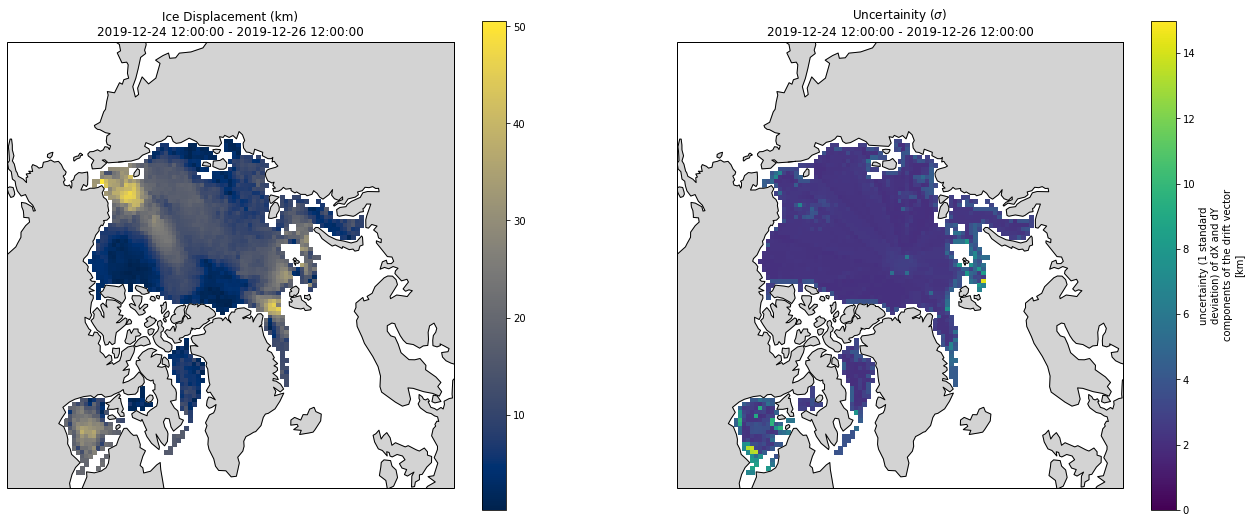

In [272]:
fig, (data_ax, uncert_ax) = plt.subplots(figsize=(22,9), ncols=2, sharex=True, sharey=True, subplot_kw={'projection': crs})
data_ax.set_extent([-3.5e6, 3.5e6, -3.5e6, 3.5e6], crs=crs)
data_ax.coastlines(zorder=3)
data_ax.add_feature(cfeature.LAND.with_scale('110m'), facecolor='lightgrey', zorder=2)
xr.plot.pcolormesh((u ** 2 + v ** 2) ** 0.5, zorder=2, ax=data_ax, cmap='cividis')
data_ax.set_title('Ice Displacement (km)\n%s - %s' % (ds.attrs['start_date'], ds.attrs['stop_date']))
uncert_ax.coastlines(zorder=3)
uncert_ax.add_feature(cfeature.LAND.with_scale('110m'), facecolor='lightgrey', zorder=2)
xr.plot.pcolormesh(uncertainty, zorder=2, vmin=0, vmax=15, ax=uncert_ax, cmap='viridis')
uncert_ax.set_title('Uncertainity ($\sigma$)\n%s - %s' % (ds.attrs['start_date'], ds.attrs['stop_date']));

### above, as histograms

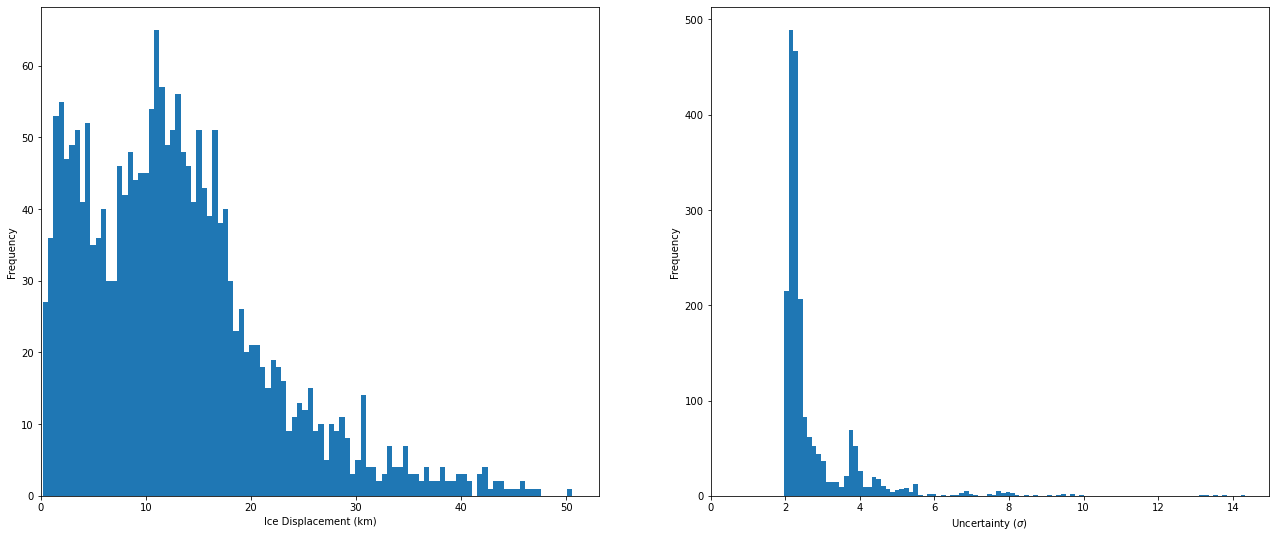

In [269]:
fig, (data_ax, uncert_ax) = plt.subplots(figsize=(22,9), ncols=2, subplot_kw={'ylabel': 'Frequency'})
xr.plot.hist((u ** 2 + v ** 2) ** 0.5, ax=data_ax, bins=100)
data_ax.set_title(None)
data_ax.set_xlim(left=0)
data_ax.set_xlabel('Ice Displacement (km)')
xr.plot.hist(uncertainty, ax=uncert_ax, bins=100)
uncert_ax.set_xlabel('Uncertainty ($\sigma$)')
uncert_ax.set_xlim(left=0)
uncert_ax.set_title(None);